## 收集数据
- tweet无法访问 :)
- 从github仓库[https://github.com/udacity/new-dand-advanced-china](https://github.com/udacity/new-dand-advanced-china)中下载文件

In [292]:
# -*- coding=utf-8 -*-
import requests

def download(url):
    with open(url.split('/')[-1], mode="wb") as f:
        respone = requests.get(url)
        f.write(respone.content)
        
# 下载 image-predictions.tsv
image_prediction_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv"
download(image_prediction_url)
# 下载 twitter-archive-enhanced.csv
twitter_archive_enhanced = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/twitter-archive-enhanced.csv"
download(twitter_archive_enhanced)
# 下载 tweet_json.txt
tweet_json_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/tweet_json.txt"
download(tweet_json_url)

## 评估数据

In [293]:
# 使用pandas模块
import pandas as pd
# 使用numpy模块
import numpy as np

### 查看`twitter-archive-enhanced.csv`的数据：

In [294]:
# 读取和评估twitter-archive-enhanced.csv数据
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_enhanced.info()
twitter_archive_enhanced

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [295]:
twitter_archive_enhanced.to_excel("twitter_archive_enhanced.xls")

##### 这里使用MS Office 2013打开，发现数据是错位的，有的行甚至不是tweet_id开头，但是用pandas读取查看数据是对齐字段的。可能跟编辑器有关系，比如rating_denominator的列出现quite、None等非float类型数据，rating_numerator的数据，发现有Sierra、URL地址等非float类型数据等等。保存为xls格式重新打开查看跟pandas查看的一样，由于notebook只能显示部分行，所以在查找`质量`和`清洁度`的问题时，结合`twitter_archive_enhanced.xls`查看。

In [296]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [297]:
# 检查 tweet_id 没有发现重复的tweet
twitter_archive_enhanced.tweet_id.value_counts()

749075273010798592    1
741099773336379392    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
700462010979500032    1
780858289093574656    1
699775878809702401    1
880095782870896641    1
760521673607086080    1
776477788987613185    1
691820333922455552    1
715696743237730304    1
714606013974974464    1
760539183865880579    1
813157409116065792    1
676430933382295552    1
743510151680958465    1
837012587749474308    1
833722901757046785    1
818259473185828864    1
670704688707301377    1
667160273090932737    1
674394782723014656    1
672082170312290304    1
670093938074779648    1
759923798737051648    1
809920764300447744    1
805487436403003392    1
838085839343206401    1
                     ..
763956972077010945    1
870308999962521604    1
720775346191278080    1
785927819176054784    1
783347506784731136    1
775733305207554048    1
834209720923721728    1
825026590719483904    1
758405701903519748    1
668986018524233728    1
6909388994772213

In [298]:
# 检查 rating_numerator
# 发现值为0或有较大（>100？）的分子
twitter_archive_enhanced.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [299]:
# 检查 rating_denominator
# 发现值为0或者不为10的分母
twitter_archive_enhanced.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

### 发现`twitter-archive-enhanced.csv`存在以下问题
#### 质量
- in_reply_to_status_id、in_reply_to_user_id、retweeted_status_id、retweeted_status_user_id、retweeted_status_timestamp的缺失的数据较多
- expanded_urls的数据，有的记录存在多个相同的url，应该去重，而且expanded_urls存在数据缺失
- rating_numerator的数据，翻看xls格式数据发现有的数值小于rating_denominator
- rating_denominator的数据，发现值为0或者不为10的分母（转换为10为分母的分数），0不能当分母
- text的数据，存在多个分数时，只获取了一个分数，这里应该要取多个分数的平均值
- timestamp的数据是object类型，要转换成date类型的数据
- name的数据，有的是a或者an，需要把这样的数据改成null。例如This is Adele.提取name为Adele；但是This is a rare Arctic Wubberfloof.提取a是不正确的，不能通过This is <dog_name>.的方式来提取狗的名字。
- doggo/floofer/pupper/puppo的数据，有的是'None'字符串，其实应该替换为null，表示数据的缺失。
- retweeted_status_id的字段有数据，说明有些数据是转发的，需要清理掉转发的数据
- 总记录数是2356，而expanded_urls只有2297，需要通过image-predictions.tsv的数据来清理没有照片的数据

#### 清洁度
- source字段内容是html文本，只需要获取该html的text部分即可
- twitter_archive_enhanced缺少`favorite_count`和`retweet_count`，需要从tweet_json.txt中获取后合并到twitter_archive_enhanced中
- doggo/floofer/pupper/puppo的数据是狗的不同等级，这里可以切换为同一列数据，而不是分成4个字段

In [300]:
# 处理和评估tweet_json.txt数据
import json
with open("tweet_json.txt", 'r') as json_file:
    for data in json_file.readlines():
        print(json.dumps(json.loads(data), indent=4, sort_keys=False, ensure_ascii=True))
        break

{
    "created_at": "Tue Aug 01 16:23:56 +0000 2017",
    "id": 892420643555336193,
    "id_str": "892420643555336193",
    "full_text": "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
    "truncated": false,
    "display_text_range": [
        0,
        85
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "user_mentions": [],
        "urls": [],
        "media": [
            {
                "id": 892420639486877696,
                "id_str": "892420639486877696",
                "indices": [
                    86,
                    109
                ],
                "media_url": "http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "media_url_https": "https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "url": "https://t.co/MgUWQ76dJU",
                "display_url": "pic.twitter.com/MgUWQ76dJU",
                "expanded_url": "https://twitter.com/dog_rat

In [301]:
# 逐行读取tweet_json.txt文件并添加到pandas DataFrame中，（至少）包含 tweet ID、retweet_count和favorite_count字段...
df_tweet = pd.DataFrame()

# 观察tweet_json.txt后，favorite_count和retweet_count跟id平级，通过一下方式组织数据：
with open("tweet_json.txt", 'r') as json_file:
    indexs = ['id', 'favorite_count', 'retweeted', 'retweet_count']
    for data in json_file.readlines():
        dict_data = json.loads(data)
        
        data = []
        for idx in indexs:
            data.append(dict_data[idx])
        
        s_tweet = pd.Series(data, index=indexs)
        df_tweet = df_tweet.append(s_tweet, ignore_index=True)

In [302]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 4 columns):
favorite_count    2352 non-null float64
id                2352 non-null float64
retweet_count     2352 non-null float64
retweeted         2352 non-null float64
dtypes: float64(4)
memory usage: 73.6 KB


In [303]:
df_tweet.describe()
df_tweet.sample(5)

,favorite_count,id,retweet_count,retweeted
1728,39558.0,6.798284e+17,15743.0,0.0
437,14243.0,8.199242e+17,5576.0,0.0
1848,2141.0,6.757073e+17,767.0,0.0
2314,542.0,6.664547e+17,219.0,0.0
1828,2464.0,6.761918e+17,1142.0,0.0


###### 通过`describe()`观察`retweeted`的数据可以知道tweet_json.txt的数据都是原始平级

## 清理

In [304]:
# 清理前的备份
# df_tweet_clean = df_tweet[['id', 'retweet_count', 'favorite_count']].copy()
df_tweet_clean =  df_tweet.copy()
twitter_archive_enhanced_clean = twitter_archive_enhanced.copy()

#### `expanded_url`: 有多个相同的url，应该去重，去掉非http开头的数据

##### 定义
清理重复的url数据，清空非http地址的数据

##### 代码

In [305]:
# 清理掉不是http开头的，清理重复的url
# 注意：这里用list，是要处理可能有3个及以上的分数的情况
def clean_urls(urls):
    if not str(urls).startswith('http'):
        return np.NaN
    urls_list = urls.split(',')
    urls_list_clean = []
    for url in urls_list:
        if url not in urls_list_clean:
            urls_list_clean.append(url)
    return ','.join(urls_list_clean)

twitter_archive_enhanced_clean['expanded_urls'] = twitter_archive_enhanced_clean['expanded_urls'].map(clean_urls)

In [306]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### `rating_numerator`：翻看xls格式数据发现有的数据 分子rating_numerator小于分母rating_denominator

##### 定义
清理分子比分母小的数据。

##### 代码

In [307]:
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.rating_numerator > twitter_archive_enhanced_clean.rating_denominator]

##### 测试

In [308]:
twitter_archive_enhanced_clean.rating_numerator.value_counts().sort_index()

11      463
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
60        1
75        2
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

##### `rating_denominator`: 发现值为0或者不为10的分母，0不能当分母

##### 定义
查看并筛选清理分母为0的数据

##### 代码

In [309]:
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.rating_denominator != 0]

##### 测试

In [310]:
twitter_archive_enhanced_clean.rating_denominator.value_counts()

10     1438
170       1
150       1
130       1
120       1
110       1
90        1
80        1
70        1
50        1
40        1
16        1
7         1
Name: rating_denominator, dtype: int64

##### `text`: 存在多个分数时，只获取了一个分数，这里应该要取多个分数的平均值

##### 定义
根据 分子/分母 的正则表达式，从`text`中找出所有（两个及以上）分数后取平均值

分子为浮点数，正常情况下分母为10，如果分母不是10，等比例转换分母为10的分数
##### 代码

In [311]:
# [1-9]+\/10|[1-9]+\.?[1-9]+\/10
twitter_archive_enhanced_clean['rating'] = twitter_archive_enhanced_clean.text.str.findall(r'^[1-9][0-9]+\/[1-9][0-9]+|[1-9]+\.?[1-9]+\/[1-9][0-9]+')
for i in twitter_archive_enhanced_clean.rating:
    print(i)

['13/10']
['13/10']
['12/10']
['13/10']
['12/10']
['13/10']
['13/10']
['13/10']
['13/10']
['14/10']
['13/10']
['13/10']
['13/10']
['12/10']
['13/10']
['13/10']
['12/10']
['13/10']
['13/10']
['13/10']
['12/10']
['13/10']
['14/10']
['13/10']
['13/10']
['12/10']
['13/10']
['13/10']
['13/10']
['12/10']
['12/10']
['13/10']
['12/10']
['12/10']
['13/10']
['14/10']
['13/10']
['13/10']
['12/10']
['13/10']
['13/10']
['14/10']
['13/10']
['12/10']
['12/10']
['13/10']
['13/10']
['13/10']
['12/10']
['13/10']
['13/10']
['13/10']
['12/10']
['13/10']
['17/10', '13/10']
['14/10']
['12/10']
['13/10']
['12/10']
['12/10']
['12/10']
['11/10']
['13/10']
['14/10']
['12/10']
['13/10']
['12/10']
['14/10']
['11/10']
['13/10']
['13/10']
['13/10']
['13/10']
['11/10']
['13/10']
['14/10']
['13/10']
['14/10']
['12/10']
['13/10']
['12/10']
['12/10']
['14/10']
['13/10']
['13/10']
['13/10']
['13/10']
['13/10']
['12/10']
['12/10']
['12/10']
['13/10']
['12/10']
['13/10']
['14/10']
['13/10']
['12/10']
['12/10']
['12/10']
[

In [312]:
# 字符串分数转小数，保留两位小数 float('%.2f' % a)
def str_convert_decimal(dstr):
    fz = float(dstr.split('/')[0])
    fm = float(dstr.split('/')[1])
    if fm and fz:
        return float('%.2f' % (fz/fm))
    else:
        # 如果分母或者分子为0，则返回0，表示该分数无效
        return 0


# 取平均值
def get_rating_avg(rL):
    if len(rL) == 0:
        return np.nan
    else:
        # 乘10转换为10的分母的分子
        if len(rL) == 1:
            return str_convert_decimal(rL[0])*10
        else:
            rs = 0
            # 这里用for处理可能存在的3个及以上的分数
            for r in rL:
                rs = rs + str_convert_decimal(r)
            return rs*10/len(rL)

twitter_archive_enhanced_clean['rating_avg'] = twitter_archive_enhanced_clean['rating'].map(get_rating_avg)

##### 测试

In [313]:
twitter_archive_enhanced_clean.rating_avg.value_counts() 

12.0      558
11.0      469
13.0      351
14.0       54
15.0        3
11.3        2
9.7         2
11.5        2
666.0       1
1776.0      1
182.0       1
Name: rating_avg, dtype: int64

##### 定义
~~因为分母是10，这里下决定排除分子大于100的~~

之前的步骤，以及将所有非10为分母的分数，统一转换为10
通过describe()可以知道666、1776、182等的分值很可能为异常值
##### 代码

In [314]:
twitter_archive_enhanced_clean.rating_avg.describe() 

count    1444.000000
mean       13.786704
std        49.703050
min         9.700000
25%        11.000000
50%        12.000000
75%        13.000000
max      1776.000000
Name: rating_avg, dtype: float64

In [315]:
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[ twitter_archive_enhanced_clean.rating_avg <= 100]

##### 测试

In [316]:
twitter_archive_enhanced_clean.rating_avg.value_counts()

12.0    558
11.0    469
13.0    351
14.0     54
15.0      3
11.3      2
9.7       2
11.5      2
Name: rating_avg, dtype: int64

`timestamp`: 是object类型，要转换成date类型的数据
##### 定义
使用pd.to_datetime()将objecte类型转换成date类型
##### 代码

In [317]:
# 时间字符串的格式 Tue Aug 01 16:23:56 +0000 2017
twitter_archive_enhanced_clean['timestamp_datetime'] = pd.to_datetime(twitter_archive_enhanced_clean['timestamp'])

##### 测试

In [318]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 2339
Data columns (total 20 columns):
tweet_id                      1441 non-null int64
in_reply_to_status_id         54 non-null float64
in_reply_to_user_id           54 non-null float64
timestamp                     1441 non-null object
source                        1441 non-null object
text                          1441 non-null object
retweeted_status_id           153 non-null float64
retweeted_status_user_id      153 non-null float64
retweeted_status_timestamp    153 non-null object
expanded_urls                 1404 non-null object
rating_numerator              1441 non-null int64
rating_denominator            1441 non-null int64
name                          1441 non-null object
doggo                         1441 non-null object
floofer                       1441 non-null object
pupper                        1441 non-null object
puppo                         1441 non-null object
rating                        14

`name`: 有的是a或者an，需要把这样的数据先改成null。例如This is Adele.提取name为Adele；但是This is a rare Arctic Wubberfloof.提取a是不正确的，不能通过This is <dog_name>.的方式来提取狗的名字。
##### 定义
- 1 先把a或者an改成NaN，把None改成NaN
- 2 处理NaN的数据，重新从text中提取

##### 代码

In [319]:
# 查看都有那些狗的名字
twitter_archive_enhanced_clean.name.value_counts()

None              441
a                  17
Charlie            10
Bo                  9
Oliver              9
Cooper              9
Tucker              9
Lucy                7
Jack                6
Koda                6
Daisy               6
Penny               6
Bailey              6
Lola                6
Leo                 5
Buddy               5
Scout               5
Winston             5
Rusty               5
Louis               4
Winnie              4
just                4
Dave                4
Finn                4
Bear                4
Sampson             4
Boomer              4
Jeffrey             4
Carl                4
Alfie               4
                 ... 
Ralphé              1
Autumn              1
Penelope            1
Michelangelope      1
Banjo               1
Harry               1
Sky                 1
Beebop              1
DayZ                1
Marvin              1
Raymond             1
Meera               1
Dixie               1
Aiden               1
Ginger    

In [320]:
## 查看 name 为 None a an 的数据
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.name.isin(['a', 'an', 'None'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating,rating_avg,timestamp_datetime
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None,[13/10],13.0,2017-07-29 00:08:17
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181411237888/photo/1,13,10,None,None,None,None,None,[13/10],13.0,2017-07-28 00:22:40
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,None,None,None,puppo,[13/10],13.0,2017-07-25 01:55:32
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217045368832/video/1,13,10,None,None,None,None,None,[13/10],13.0,2017-07-18 16:08:03
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392804085760/photo/1,12,10,None,None,None,None,None,[12/10],12.0,2017-07-18 00:07:08
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,[12/10],12.0,2017-07-15 16:51:35
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434075471873,12,10,None,None,None,None,None,[12/10],12.0,2017-07-15 02:45:48
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/885517367337512960,14,10,None,None,None,None,None,[14/10],14.0,2017-07-13 15:19:09
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619883638784/photo/1,13,10,None,None,None,None,None,[13/10],13.0,2017-07-12 16:03:00
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/downloa

In [321]:
# 处理缺失的 name
#import re
#def update_dog_name(text, name):
#    if name in ['a', 'an', 'None']:
#        
#        pattern1 = r"named \w+\b\.|Meet \w+\b\."
#        pattern2 = r"This is \w+\b\.|name is \w+\b\."
#        pattern3 = r"This is (?:a|an) .*?\."
#        dog_name1 = re.search(pattern1, text, flags=0)
#        dog_name2 = re.search(pattern2, text, flags=0)
#        dog_name3 = re.search(pattern3, text, flags=0)
#        
#        if dog_name1:
#            dog_name_str = dog_name1.group()
#            return ' '.join(dog_name_str.split(' ')[1:])[0:-1] # 去除最后的.号
#        if dog_name2:
#            dog_name_str = dog_name2.group()
#            return ' '.join(dog_name_str.split(' ')[2:])[0:-1]
#        if dog_name3:
#            dog_name_str = dog_name3.group()
#            return ' '.join(dog_name_str.split(' ')[3:])[0:-1]
#        return np.nan
#    else:
#        return name

#twitter_archive_enhanced_clean['dog_name'] = twitter_archive_enhanced_clean.apply(lambda row: update_dog_name(row['text'], row['name']), axis=1) 
twitter_archive_enhanced_clean['dog_name']=twitter_archive_enhanced_clean.text.str.extract('(?:This is|Meet|name is|Say hello to|named|Named) ([A-Z][a-z]{2,12})', expand=False)

##### 测试

In [322]:
twitter_archive_enhanced_clean.dog_name.value_counts()

Charlie     10
Tucker       9
Cooper       9
Oliver       9
Lucy         7
Bailey       6
Lola         6
Koda         6
Daisy        6
Penny        6
Jack         6
Leo          5
Scout        5
Winston      5
Buddy        5
Rusty        5
Dave         4
Bentley      4
Louis        4
Zoey         4
Sunny        4
Riley        4
Toby         4
Loki         4
Bear         4
Stanley      4
Winnie       4
Oscar        4
Oakley       4
Maddie       4
            ..
Aiden        1
Grizzie      1
Autumn       1
Penelope     1
Phineas      1
Pepe         1
Banjo        1
Harry        1
Sky          1
Beebop       1
Marvin       1
Raymond      1
Meera        1
Dixie        1
Ginger       1
Sobe         1
Clifford     1
Jim          1
Bilbo        1
Mairi        1
Mingus       1
Nimbus       1
Boston       1
Kirk         1
Grey         1
Percy        1
Rupert       1
Monty        1
Brooks       1
Rolf         1
Name: dog_name, Length: 619, dtype: int64

`doggo/floofer/pupper/puppo`: 有的是'None'字符串，其实应该替换为null，表示数据的缺失，处理清洁度问题

##### 定义
如果这些字段的数据，有出现字符串None的，转换为np.nan，表示缺失数据
把doggo/floofer/pupper/puppo转换成一列rank
##### 代码

In [323]:
# 定义清理函数
def clean_none(dat):
    if dat == 'None':
        return np.nan
    else:
        return dat

twitter_archive_enhanced_clean['doggo'] = twitter_archive_enhanced_clean['doggo'].map(clean_none)
twitter_archive_enhanced_clean['floofer'] = twitter_archive_enhanced_clean['floofer'].map(clean_none)
twitter_archive_enhanced_clean['pupper'] = twitter_archive_enhanced_clean['pupper'].map(clean_none)
twitter_archive_enhanced_clean['puppo'] = twitter_archive_enhanced_clean['puppo'].map(clean_none)

In [324]:
# 将doggo/floofer/pupper/puppo转换成一列rank
#def update_dog_rank(doggo, floofer, pupper, puppo):
def  update_dog_rank(*args):    
    rank_list=[]
    for arg in args:
        if str(arg) != "nan":
            rank_list.append(str(arg))
    # 有等级返回等级，四个都没有等级那么反馈nan
    if rank_list:
        return ",".join(rank_list)
    else:
        return np.nan

twitter_archive_enhanced_clean['rank'] = twitter_archive_enhanced_clean.apply(lambda row: update_dog_rank(row['doggo'], row['floofer'], row['pupper'], row['puppo']), axis=1) 

In [325]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 2339
Data columns (total 22 columns):
tweet_id                      1441 non-null int64
in_reply_to_status_id         54 non-null float64
in_reply_to_user_id           54 non-null float64
timestamp                     1441 non-null object
source                        1441 non-null object
text                          1441 non-null object
retweeted_status_id           153 non-null float64
retweeted_status_user_id      153 non-null float64
retweeted_status_timestamp    153 non-null object
expanded_urls                 1404 non-null object
rating_numerator              1441 non-null int64
rating_denominator            1441 non-null int64
name                          1441 non-null object
doggo                         83 non-null object
floofer                       9 non-null object
pupper                        159 non-null object
puppo                         26 non-null object
rating                        1441 non-n

##### 测试

In [326]:
twitter_archive_enhanced_clean['rank'].value_counts()

pupper           149
doggo             71
puppo             25
doggo,pupper      10
floofer            8
doggo,puppo        1
doggo,floofer      1
Name: rank, dtype: int64

`retweeted_status_id`清理掉转发的数据
##### 定义

`retweeted_status_id`有值，说明是转发的数据，要清理掉
##### 代码

In [327]:
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.retweeted_status_id.isnull()]

##### 测试

In [328]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 0 to 2339
Data columns (total 22 columns):
tweet_id                      1288 non-null int64
in_reply_to_status_id         54 non-null float64
in_reply_to_user_id           54 non-null float64
timestamp                     1288 non-null object
source                        1288 non-null object
text                          1288 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1252 non-null object
rating_numerator              1288 non-null int64
rating_denominator            1288 non-null int64
name                          1288 non-null object
doggo                         74 non-null object
floofer                       9 non-null object
pupper                        141 non-null object
puppo                         21 non-null object
rating                        1288 non-null ob

`expanded_urls`清理没有照片的数据
##### 定义
通过`image-predictions.tsv`的数据来清理缺失图片url的数据
##### 代码

In [329]:
# twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.expanded_urls.notnull()]
# 读取和评估image-predictions.tsv数据
image_predictions = pd.read_csv("image-predictions.tsv", sep='\t')
image_predictions.info()
image_predictions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [330]:
image_predictions_clean = image_predictions.copy()
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [331]:
# 获取url_id
twitter_archive_enhanced_clean['url_id'] = twitter_archive_enhanced_clean.expanded_urls.str.extract('([0-9]{2,20})', expand=False)

In [332]:
# tweet_id其实是expanded_urls的路径名，那么需要修改字段名为url_id称以便关联，也避免跟tweet_id字段冲突
image_predictions_clean.rename(columns={'tweet_id': 'url_id'}, inplace=True)
# merge
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean.merge(image_predictions_clean, left_on='url_id', right_on='url_id', how='left')

In [333]:
# 清理
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.jpg_url.notnull()]

##### 测试

In [334]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 0 to 1287
Data columns (total 34 columns):
tweet_id                      1148 non-null int64
in_reply_to_status_id         19 non-null float64
in_reply_to_user_id           19 non-null float64
timestamp                     1148 non-null object
source                        1148 non-null object
text                          1148 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1148 non-null object
rating_numerator              1148 non-null int64
rating_denominator            1148 non-null int64
name                          1148 non-null object
doggo                         61 non-null object
floofer                       7 non-null object
pupper                        124 non-null object
puppo                         19 non-null object
rating                        1148 non-null ob

####  `tweet_json.txt` 的质量问题

#### `id`: 这个是用来跟tweet_id进行合并的，所以要转换为int64类型
#### `favorite_count、retweet_count`: 计数应该是整数，所以要转换为int类型


##### 定义
对id做类型转换：astype(int64)
对favorite_count、id、retweet_count做类型转换：astype(int)

##### 代码

In [335]:
df_tweet_clean['id'] = df_tweet_clean['id'].astype(np.int64)
df_tweet_clean['favorite_count'] = df_tweet_clean['favorite_count'].astype('int')
df_tweet_clean['retweet_count'] = df_tweet_clean['retweet_count'].astype('int')

##### 测试

In [336]:
df_tweet_clean.info()
df_tweet_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 4 columns):
favorite_count    2352 non-null int32
id                2352 non-null int64
retweet_count     2352 non-null int32
retweeted         2352 non-null float64
dtypes: float64(1), int32(2), int64(1)
memory usage: 55.2 KB


,favorite_count,id,retweet_count,retweeted
0,39492,892420643555336192,8842,0.0
1,33786,892177421306343424,6480,0.0
2,25445,891815181378084864,4301,0.0
3,42863,891689557279858688,8925,0.0
4,41016,891327558926688256,9721,0.0


#### `retweeted`: 应该是bool类型

##### 定义
对retweeted做类型转换：astype('bool')

##### 代码

In [337]:
df_tweet_clean['retweeted'] = df_tweet_clean['retweeted'].astype(bool)
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 4 columns):
favorite_count    2352 non-null int32
id                2352 non-null int64
retweet_count     2352 non-null int32
retweeted         2352 non-null bool
dtypes: bool(1), int32(2), int64(1)
memory usage: 39.1 KB


##### 测试
可以看出，tweet_json.txt的数据都是原始评级的数据。

In [338]:
df_tweet_clean.retweeted.value_counts()

False    2352
Name: retweeted, dtype: int64

## 清洁度

`source`: 获取text内容
##### 定义
source字段内容是html文本，只需要获取该html的text部分即可
##### 代码

In [339]:
twitter_archive_enhanced_clean['source_text'] = twitter_archive_enhanced_clean.source.str.findall(r'>.*<').astype(str).str[3:-3]

##### 测试

In [340]:
twitter_archive_enhanced_clean.source_text.value_counts()

Twitter for iPhone    1126
Twitter Web Client      15
TweetDeck                7
Name: source_text, dtype: int64

`favorite_count`和`retweet_count`:twitter_archive_enhanced缺少favorite_count和retweet_count，需要从tweet_json.txt中获取后合并到twitter_archive_enhanced中
##### 定义
通过twitter_archive_enhanced.tweet_id和tweet_json.id关联，合并favorite_count和retweet_count；

合并后，将tweet_id改为str类型
##### 代码


In [341]:
twitter_archive_master = twitter_archive_enhanced_clean.merge(df_tweet_clean, left_on='tweet_id', right_on='id', how='left')
twitter_archive_master['tweet_id'] = twitter_archive_master['tweet_id'].astype(str)

##### 测试

In [342]:
twitter_archive_master.info()
twitter_archive_master.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 0 to 1147
Data columns (total 39 columns):
tweet_id                      1148 non-null object
in_reply_to_status_id         19 non-null float64
in_reply_to_user_id           19 non-null float64
timestamp                     1148 non-null object
source                        1148 non-null object
text                          1148 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1148 non-null object
rating_numerator              1148 non-null int64
rating_denominator            1148 non-null int64
name                          1148 non-null object
doggo                         61 non-null object
floofer                       7 non-null object
pupper                        124 non-null object
puppo                         19 non-null object
rating                        1148 non-null o

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,source_text,favorite_count,id,retweet_count,retweeted
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,0.085851,False,banana,0.076110,False,Twitter for iPhone,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,0.090647,True,papillon,0.068957,True,Twitter for iPhone,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,0.078253,True,kelpie,0.031379,True,Twitter for iPhone,25445.0,8.918152e+17,4301.0,False
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,0.168086,True,spatula,0.040836,False,Twitter for iPhone,42863.0,8.916896e+17,8925.0,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558926688256/photo/1,...,0.225770,True,German_short-haired_pointer,0.175219,True,Twitter for iPhone,41016.0,8.913276e+17,9721.0,False


#### 保存最终数据

##### 定义
只保存需要的列数据
##### 代码

In [391]:
# 只保留部分列
cols = ['tweet_id', 'timestamp_datetime', 'text', 'dog_name','rating_avg', 'source_text', 'jpg_url','favorite_count', 'retweet_count','rank']
twitter_archive_master_save = pd.DataFrame(twitter_archive_master, columns=cols)
twitter_archive_master_save.info()
twitter_archive_master_save

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 0 to 1147
Data columns (total 10 columns):
tweet_id              1148 non-null object
timestamp_datetime    1148 non-null datetime64[ns]
text                  1148 non-null object
dog_name              811 non-null object
rating_avg            1148 non-null float64
source_text           1148 non-null object
jpg_url               1148 non-null object
favorite_count        717 non-null float64
retweet_count         717 non-null float64
rank                  202 non-null object
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 98.7+ KB


,tweet_id,timestamp_datetime,text,dog_name,rating_avg,source_text,jpg_url,favorite_count,retweet_count,rank
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12.0,Twitter for iPhone,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,25445.0,4301.0,NaN
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,42863.0,8925.0,NaN
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",Franklin,12.0,Twitter for iPhone,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,41016.0,9721.0,NaN
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,20548.0,3240.0,NaN
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,Jax,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,NaN,NaN,NaN
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,66596.0,19548.0,NaN
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,Zoey,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,28187.0,4403.0,NaN
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,Cassie,14.0,Twitter for iPhone,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,NaN,NaN,doggo


In [392]:
# 把数据保存到 twitter_archive_master.csv
twitter_archive_master_save.to_csv('twitter_archive_master.csv', index=False)

## 数据分析和可视化

In [394]:
# -*- coding=utf-8 -*-
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# 读取twitter_archive_master.csv
twitter_archive_view = pd.read_csv("twitter_archive_master.csv")
# twitter_archive_view = twitter_archive_master_save.copy()
twitter_archive_view.info()
twitter_archive_view.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 10 columns):
tweet_id              1148 non-null int64
timestamp_datetime    1148 non-null object
text                  1148 non-null object
dog_name              811 non-null object
rating_avg            1148 non-null float64
source_text           1148 non-null object
jpg_url               1148 non-null object
favorite_count        717 non-null float64
retweet_count         717 non-null float64
rank                  202 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 89.8+ KB


,tweet_id,timestamp_datetime,text,dog_name,rating_avg,source_text,jpg_url,favorite_count,retweet_count,rank
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,Twitter for iPhone,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12.0,Twitter for iPhone,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,25445.0,4301.0,NaN


In [395]:
twitter_archive_view.describe()

,tweet_id,rating_avg,favorite_count,retweet_count
count,1.148000e+03,1148.000000,717.000000,717.000000
mean,7.655291e+17,11.934495,12257.276151,3604.878661
std,7.012779e+16,0.835458,13289.179825,4718.016494
min,6.661022e+17,9.700000,81.000000,15.000000
25%,6.957880e+17,11.000000,3255.000000,1059.000000
50%,7.665032e+17,12.000000,8095.000000,2213.000000
75%,8.258414e+17,13.000000,17023.000000,4363.000000
max,8.924206e+17,14.000000,106634.000000,56373.000000


##### 可以看出这份清理后的数据，得分均值是12分，75%是13分，最高分值是15分。

#### 查看转发数最多的tweet

In [396]:
pd.set_option('max_colwidth',1000)
twitter_archive_view[twitter_archive_view.retweet_count==twitter_archive_view.retweet_count.max()].text

385    This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d
Name: text, dtype: object

#### 查看favorite最多的tweet

In [397]:
twitter_archive_view[twitter_archive_view.favorite_count==twitter_archive_view.favorite_count.max()].text

385    This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d
Name: text, dtype: object

#### 分值最大的狗的推文

In [398]:
twitter_archive_view[twitter_archive_view.rating_avg==twitter_archive_view.rating_avg.max()]

,tweet_id,timestamp_datetime,text,dog_name,rating_avg,source_text,jpg_url,favorite_count,retweet_count,rank
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,Cassie,14.0,Twitter for iPhone,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,NaN,NaN,doggo
21,887517139158093824,2017-07-19 03:39:09,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,14.0,Twitter for iPhone,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,46940.0,12053.0,NaN
36,884441805382717440,2017-07-10 15:58:53,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",NaN,14.0,Twitter for iPhone,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,27443.0,5836.0,NaN
48,881536004380872706,2017-07-02 15:32:16,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \r\n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,14.0,Twitter for iPhone,https://pbs.twimg.com/ext_tw_video_thumb/881535971568889856/pu/img/9bawiZ--8FKywTkz.jpg,NaN,NaN,pupper
63,878057613040115712,2017-06-23 01:10:23,This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,Emmy,14.0,Twitter for iPhone,https://pbs.twimg.com/media/DC98vABUIAA97pz.jpg,42743.0,7118.0,NaN
94,870063196459192321,2017-05-31 23:43:25,Meet Clifford. He's quite large. Also red. Good w kids. Somehow never steps on them. Massive poops very inconvenient. Still 14/10 would ride https://t.co/apVOyDgOju,Clifford,14.0,Twitter for iPhone,https://pbs.twimg.com/media/DBMV3NnXUAAm0Pp.jpg,NaN,NaN,NaN
99,868880397819494401,2017-05-28 17:23:24,This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,Walter,14.0,Twitter for iPhone,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,NaN,NaN,NaN
112,864873206498414592,2017-05-17 16:00:15,We only rate dogs. Please don't send in Jesus. We're trying to remain professional and legitimate. Thank you... 14/10 https://t.co/wr3xsjeCIR,NaN,14.0,Twitter for iPhone,https://pbs.twimg.com/media/DAClmHkXcAA1kSv.jpg,33537.0,9320.0,NaN
118,863079547188785154,2017-05-12 17:12:53,"Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,14.0,Twitter for iPhone,https://pbs.twimg.com/media/C_pGRInUwAAmTY_.jpg,NaN,NaN,NaN
130,860184849394610176,2017-05-04 17:30:24,"Here we have perhaps the wisest dog of all. Above average with light sabers. Immortal as h*ck. 14/10 dog, or dog not, there is no try https://t.co/upRYxG4KbG",NaN,14.0,Twitter for iPhone,https://pbs.twimg.com/media/C-_9jWWUwAAnwkd.jpg,17429.0,6277.0,NaN


#### favorite_count和retweet_count有什么关系？

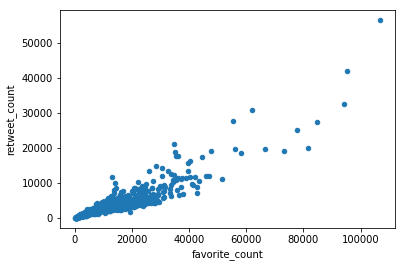

In [399]:
x = twitter_archive_view['favorite_count']
y = twitter_archive_view['retweet_count']
twitter_archive_view[['favorite_count', 'retweet_count']].plot(kind='scatter', x='favorite_count', y='retweet_count')

从图中可以看出，当favorite越高时，reweet则越高。这跟实际相符，favorite的人越多，那么该推文受到的关注就更多，那么出现转发的可能性就越大，最后导致转发数增多。

#### 这些推文，通过什么渠道发出的？我们通过source_text来分析下：

In [400]:
twitter_archive_view.source_text.value_counts()

Twitter for iPhone    1126
Twitter Web Client      15
TweetDeck                7
Name: source_text, dtype: int64

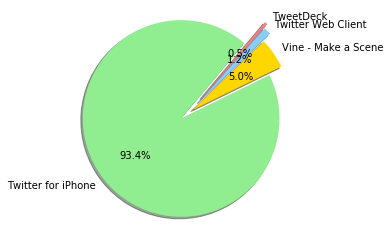

In [401]:
# 画图
labels = 'Twitter for iPhone','Vine - Make a Scene','Twitter Web Client','TweetDeck'
sizes = 1334,71,17,7
colors='lightgreen','gold','lightskyblue','lightcoral'
explode=0.1,0.05,0.15,0.2
plt.pie(sizes,explode=explode,labels=labels,
        colors=colors,autopct='%1.1f%%',shadow=True, startangle=50)
plt.axis('equal')
plt.show()

The End.